# Clustering Crypto

In [ ]:
# Author: Jonathan Matos
# Homework: 13-AWS Lex
# Date: 26 November 2019
# Columbia Engineering Financial Engineering

In [249]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from path import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [250]:
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [251]:
# Creating a DataFrame
file_path = Path("crypto_data.csv")

df_crypto = pd.read_csv(file_path, index_col='Unnamed: 0')

df_crypto.head()


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [252]:
df_crypto.isnull().sum()

CoinName             0
Algorithm            0
IsTrading            0
ProofType            0
TotalCoinsMined    508
TotalCoinSupply      0
dtype: int64

In [253]:
df_crypto.dropna(inplace=True)

In [254]:
df_crypto.isnull().sum()

CoinName           0
Algorithm          0
IsTrading          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

In [255]:
df_crypto.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000


In [256]:
# Keep only cryptocurrencies that are on trading
df_crypto.drop(df_crypto[df_crypto['IsTrading'] == False].index, inplace=True)

In [257]:
# Keep only cryptocurrencies with a working algorithm
df_crypto.drop(df_crypto[df_crypto['TotalCoinsMined'] == 0].index, inplace=True)

In [258]:
# Remove the "IsTrading" column
df_crypto.drop("IsTrading", axis=1, inplace=True)

In [259]:
# Removing rows with at least 1 null value
df_crypto.dropna(inplace=True)

In [260]:
# Removing rows with cryptocurrencies without coins mined
name = df_crypto.copy()

In [261]:
# Dropping rows where there are 'N/A' text values
df_crypto = df_crypto[df_crypto!='N/A']

In [262]:
# Fetching the cryptocurrencies names prior to drop them from df_crypto
name = df_crypto.copy()

In [263]:
# Removig the cryptocurrency name since it's not going to be used on the clustering algorithm
df_crypto.drop('CoinName', axis=1, inplace=True)

In [264]:
# Creating dummies variables for text features
crypto_binary_encoded= pd.get_dummies(df_crypto, columns=['Algorithm', 'ProofType'])

In [265]:
# Standardizing data
crypto_scaled = StandardScaler().fit_transform(crypto_binary_encoded)

crypto_scaled

array([[-0.11674788, -0.15286468, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.09358885, -0.14499604, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [ 0.52587231,  4.4937636 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       ...,
       [-0.09523411, -0.13215444, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11658774, -0.15255408, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11674507, -0.15284989, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ]])

### Reducing Dimensions Using PCA

In [266]:
# Using PCA to reduce dimension to 3 principal components
pca = PCA(n_components=3)
coin_pca = pca.fit_transform(crypto_scaled)

In [267]:
# Creating a DataFrame with the principal components data
df_crypto_pca= pd.DataFrame(data=crypto_pca, columns=["PC1", "PC2", "PC3"], index= df_crypto.index)

df_crypto_pca.head()

,PC1,PC2,PC3
42,-0.321849,0.864247,-0.575374
404,-0.305145,0.864188,-0.575969
1337,2.336208,1.490476,-0.634321
BTC,-0.161793,-1.314579,0.194984
ETH,-0.163292,-1.999005,0.350750


### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [268]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)


In [269]:
# Create the Elbow Curve using hvPlot
elbow_curve = {"k": k, "inertia": inertia}
df_curve = pd.DataFrame(elbow_curve)
df_curve.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<you best value for k here>`

In [270]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fit the model
model.fit(df_crypto_pca)
# Predict clusters
predictions = model.predict(df_crypto_pca)
# Creating a new DataFrame including predicted clusters and cryptocurrencies features
df_crypto_pca["class"] = model.labels_
df_crypto_pca.head()

,PC1,PC2,PC3,class
42,-0.321849,0.864247,-0.575374,0
404,-0.305145,0.864188,-0.575969,0
1337,2.336208,1.490476,-0.634321,0
BTC,-0.161793,-1.314579,0.194984,3
ETH,-0.163292,-1.999005,0.350750,3


### Visualizing Results

#### 3D-Scatter with Clusters

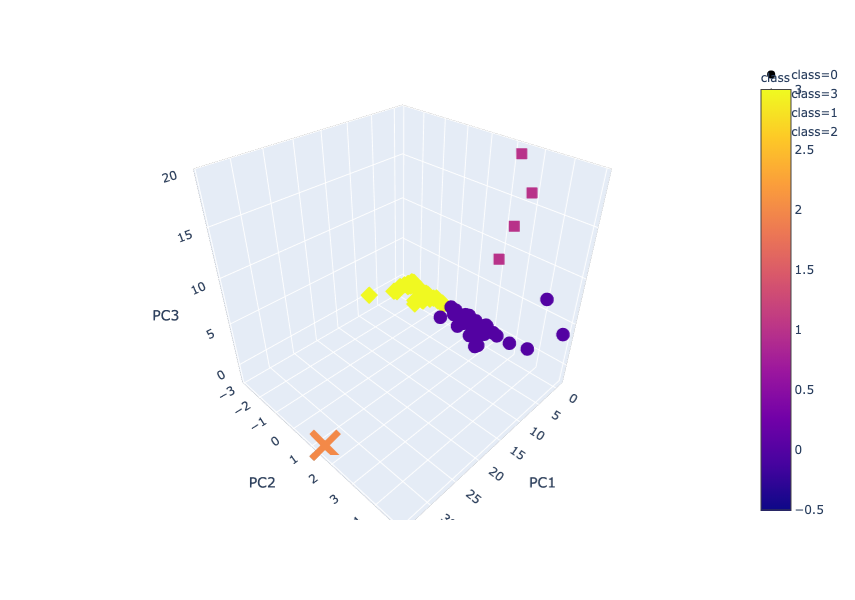

In [271]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig_scatter = px.scatter_3d(df_crypto_pca, x="PC1", y="PC2", z="PC3", color="class", symbol="class", width=650)
fig_scatter.show()

#### Table of Tradable Cryptocurrencies

In [272]:
# Table with tradable cryptos
clustered = pd.merge(name, df_crypto_pca, left_index=True, right_index=True)
clustered.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,class
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42,-0.321849,0.864247,-0.575374,0
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.305145,0.864188,-0.575969,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359,2.336208,1.490476,-0.634321,0
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000,-0.161793,-1.314579,0.194984,3
ETH,Ethereum,Ethash,PoW,1.076842e+08,0,-0.163292,-1.999005,0.350750,3


#### Scatter Plot with Tradable Cryptocurrencies

In [273]:
# Scaling data to create the scatter plot
features = clustered.copy()

#selecct columns to scale
columns_names = ['TotalCoinsMined', 'TotalCoinSupply']
features_1 = features[columns_names]

#scale with MinMaxScaler scaler
scaler = MinMaxScaler().fit(features_1.values)
features_1 = scaler.transform(features_1.values)

#amend columns with scaled values
features[columns_names] = features_1
features


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,class
42,42 Coin,Scrypt,PoW/PoS,0.005942,4.200000e-11,-0.321849,0.864247,-0.575374,0
404,404Coin,Scrypt,PoW/PoS,0.007002,5.320000e-04,-0.305145,0.864188,-0.575969,0
1337,EliteCoin,X13,PoW/PoS,0.035342,3.141593e-01,2.336208,1.490476,-0.634321,0
BTC,Bitcoin,SHA-256,PoW,0.005960,2.100000e-05,-0.161793,-1.314579,0.194984,3
ETH,Ethereum,Ethash,PoW,0.006050,0.000000e+00,-0.163292,-1.999005,0.350750,3
...,...,...,...,...,...,...,...,...,...
ZEPH,ZEPHYR,SHA-256,DPoS,0.007951,2.000000e-03,2.446497,0.901223,-0.248776,0
GAP,Gapcoin,Scrypt,PoW/PoS,0.005957,2.500000e-04,-0.319889,0.864105,-0.575396,0
BDX,Beldex,CryptoNight,PoW,0.006927,1.400223e-03,0.316974,-2.256328,0.424345,3
ZEN,Horizen,Equihash,PoW,0.005950,2.100000e-05,-0.125882,-1.927045,0.315088,3


In [274]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
features.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply")

:Scatter   [TotalCoinsMined]   (TotalCoinSupply)